In [ ]:
suppressMessages(library(rwwa))

# Fit pointwise trends

In [23]:
# load covariate data
gmst = read.table("gmst.txt", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2025]

# define factual & counterfactual covariates
cov_2024 <- gmst[gmst$year == 2025,"gmst", drop = F]
cov_cf <- rbind("pi" = cov_2024 - 1.3)

model_args <- list("dsr5x" = list(dist = "gev", type = "shift", lower = F),
                   "dsr10x" = list(dist = "gev", type = "shift", lower = F),
                   "t2m-jja" = list(dist = "norm", type = "shift", lower = F),
                   "tmax-jja" = list(dist = "norm", type = "shift", lower = F),
                   "tp-jja" = list(dist = "norm", type = "fixeddisp", lower = T),
                   "logtp-jja" = list(dist = "norm", type = "shift", lower = T))

In [28]:
for(varnm in c("dsr10x","dsr5x", "t2m-jja", "tmax-jja", "tp-jja", "logtp-jja")[1]) {

    mdl_args <- model_args[[varnm]]
    
    fnm <- paste0("pointwise/",varnm,"-flattened_era5.csv")
    res_fnm <- gsub("flattened", paste0("flattened-res-",gsub("_","",mdl_args$dist)), fnm)
    
    if (!file.exists(res_fnm)) {
        # load data
        df <- read.csv(fnm, skip = 3, header = F)
        colnames(df)[1] <- "year"
        df <- merge(gmst, df)

        # fit nonstationary model to all columns
        models <- sapply(colnames(df)[grepl("V", colnames(df))], function(cnm) {
            df_c <- df[,c("year", "gmst", cnm)]
            tryCatch({
                do.call(fit_ns, append(mdl_args, list("data" = df_c, "covnm" = "gmst", "varnm" = cnm)))
            }, error = function(cond) { return(NULL) })
        }, simplify = F)
        
        # get all model results & save as .csv to be reconstructed & plotted in python
        fitted_res <- sapply(models, function(mdl) {
            if(!is.null(unlist(mdl)[1])) {
                mdl_ests(mdl, cov_f = cov_2024, cov_cf = cov_cf)
            } else {
                rep(NA, 11)
            }})
        write.csv(fitted_res, res_fnm)
    }
}

In [18]:
ns_loglik <- function(pars, cov, x, dist, fittype) {

  nspars <- get.ns_pars(fittype = fittype, pars = pars, fixed_cov = cov)

  loc <- nspars$loc
  scale <- nspars$scale
  shape <- nspars$shape

  # constrain variance to be strictly positive
  if(any(scale <= 0)) return(NA)

  # return negative log-likelihood
  if (dist %in% c("norm")) {
    return(-sum(dnorm(x, mean = loc, sd = scale, log = T)))
  } else if (dist %in% c("norm_logt")) {
    return(sum(x)-sum(dnorm(x, mean = loc, sd = scale, log = T)))
  } else if (dist == "gev") {
    shape = pars["shape"]
    return(-sum(devd(x, loc = loc, scale = scale, shape = shape, log = T)))
  } else if (dist == "gumbel") {
    return(-sum(devd(x, loc = loc, scale = scale, shape = 0, log = T)))
  } else {
    print(paste(dist, "not implemented"))
    return()
  }
}

# JJA precip

In [33]:
ts = read.csv("data/ts_tp-jja_era5_1950-2025.csv")

# load covariate data
gmst = read.table("gmst.txt", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2025]

# define factual & counterfactual covariates
cov_2024 <- gmst[gmst$year == 2025,"gmst", drop = F]
cov_cf <- rbind("pi" = cov_2024 - 1.3)

df <- merge(gmst, ts)

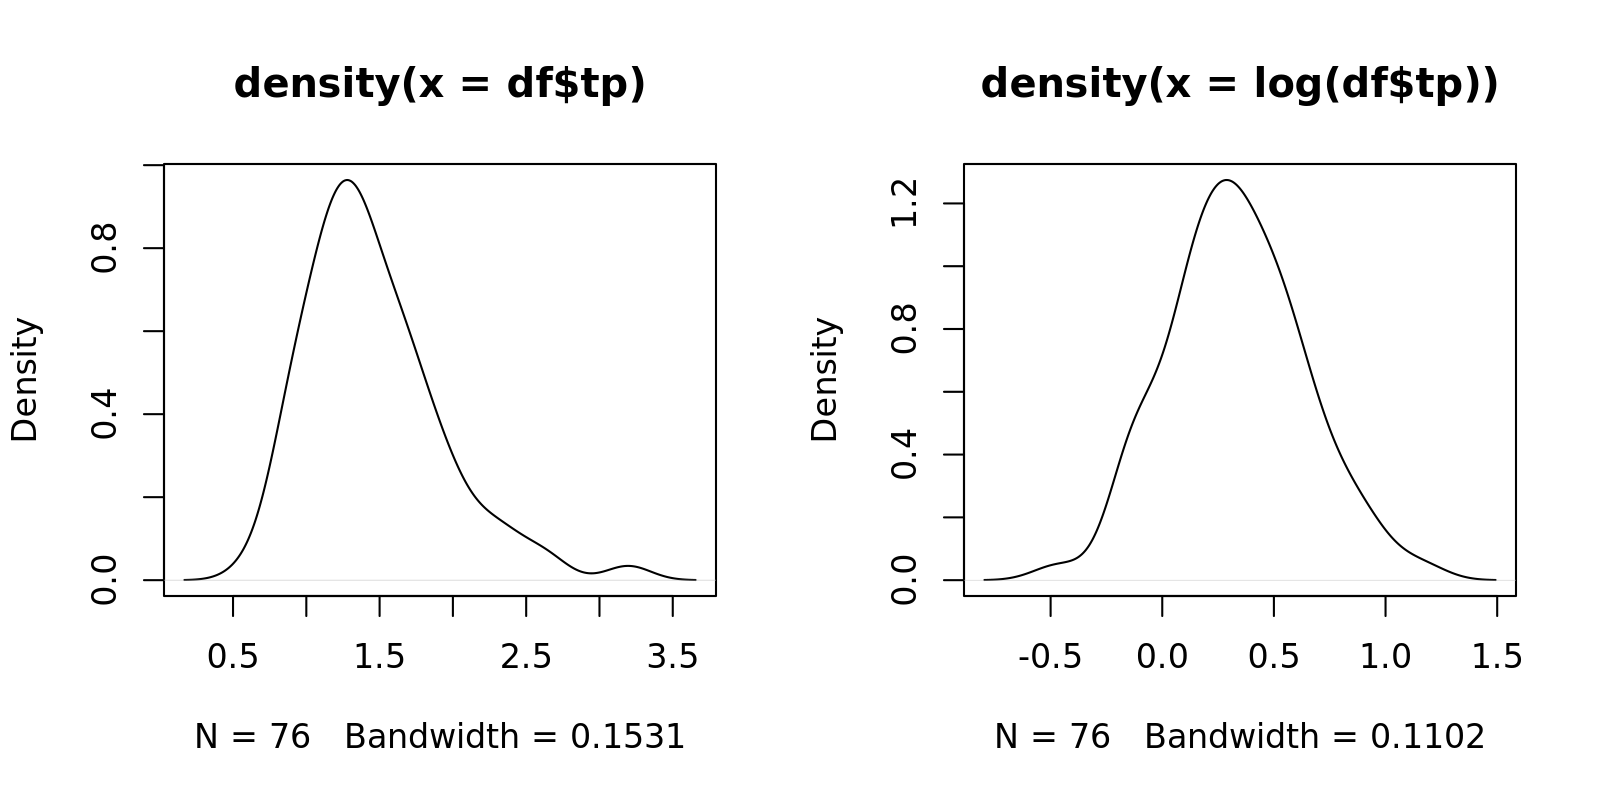

In [38]:
prep_window(c(1,2))

plot(density(df$tp))
plot(density(log(df$tp)))

In [47]:
mdl_norm <- fit_ns("norm", "fixeddisp", data = df, varnm = "tp", covnm = "gmst", lower = T)
mdl_normss <- fit_ns("norm", "shiftscale", data = df, varnm = "tp", covnm = "gmst", lower = T)
mdl_normlog <- fit_ns("norm", "shift", data = df, varnm = "logtp", covnm = "gmst", lower = T)

In [62]:
sapply(list("norm_fd" = mdl_norm, "norm_shiftscale" = mdl_normss, "norm_logged" = mdl_normlog), aic)

norm_fd norm_shiftscale     norm_logged 
       101.2730        101.2333         39.5975

In [63]:
fit_ns("norm_logt", "shift", data = df, varnm = "tp", covnm = "gmst", lower = T)

ERROR: Error in optim(par = init, ns_loglik, cov = cov, x = x, dist = dist, fittype = type, : initial value in 'vmmin' is not finite


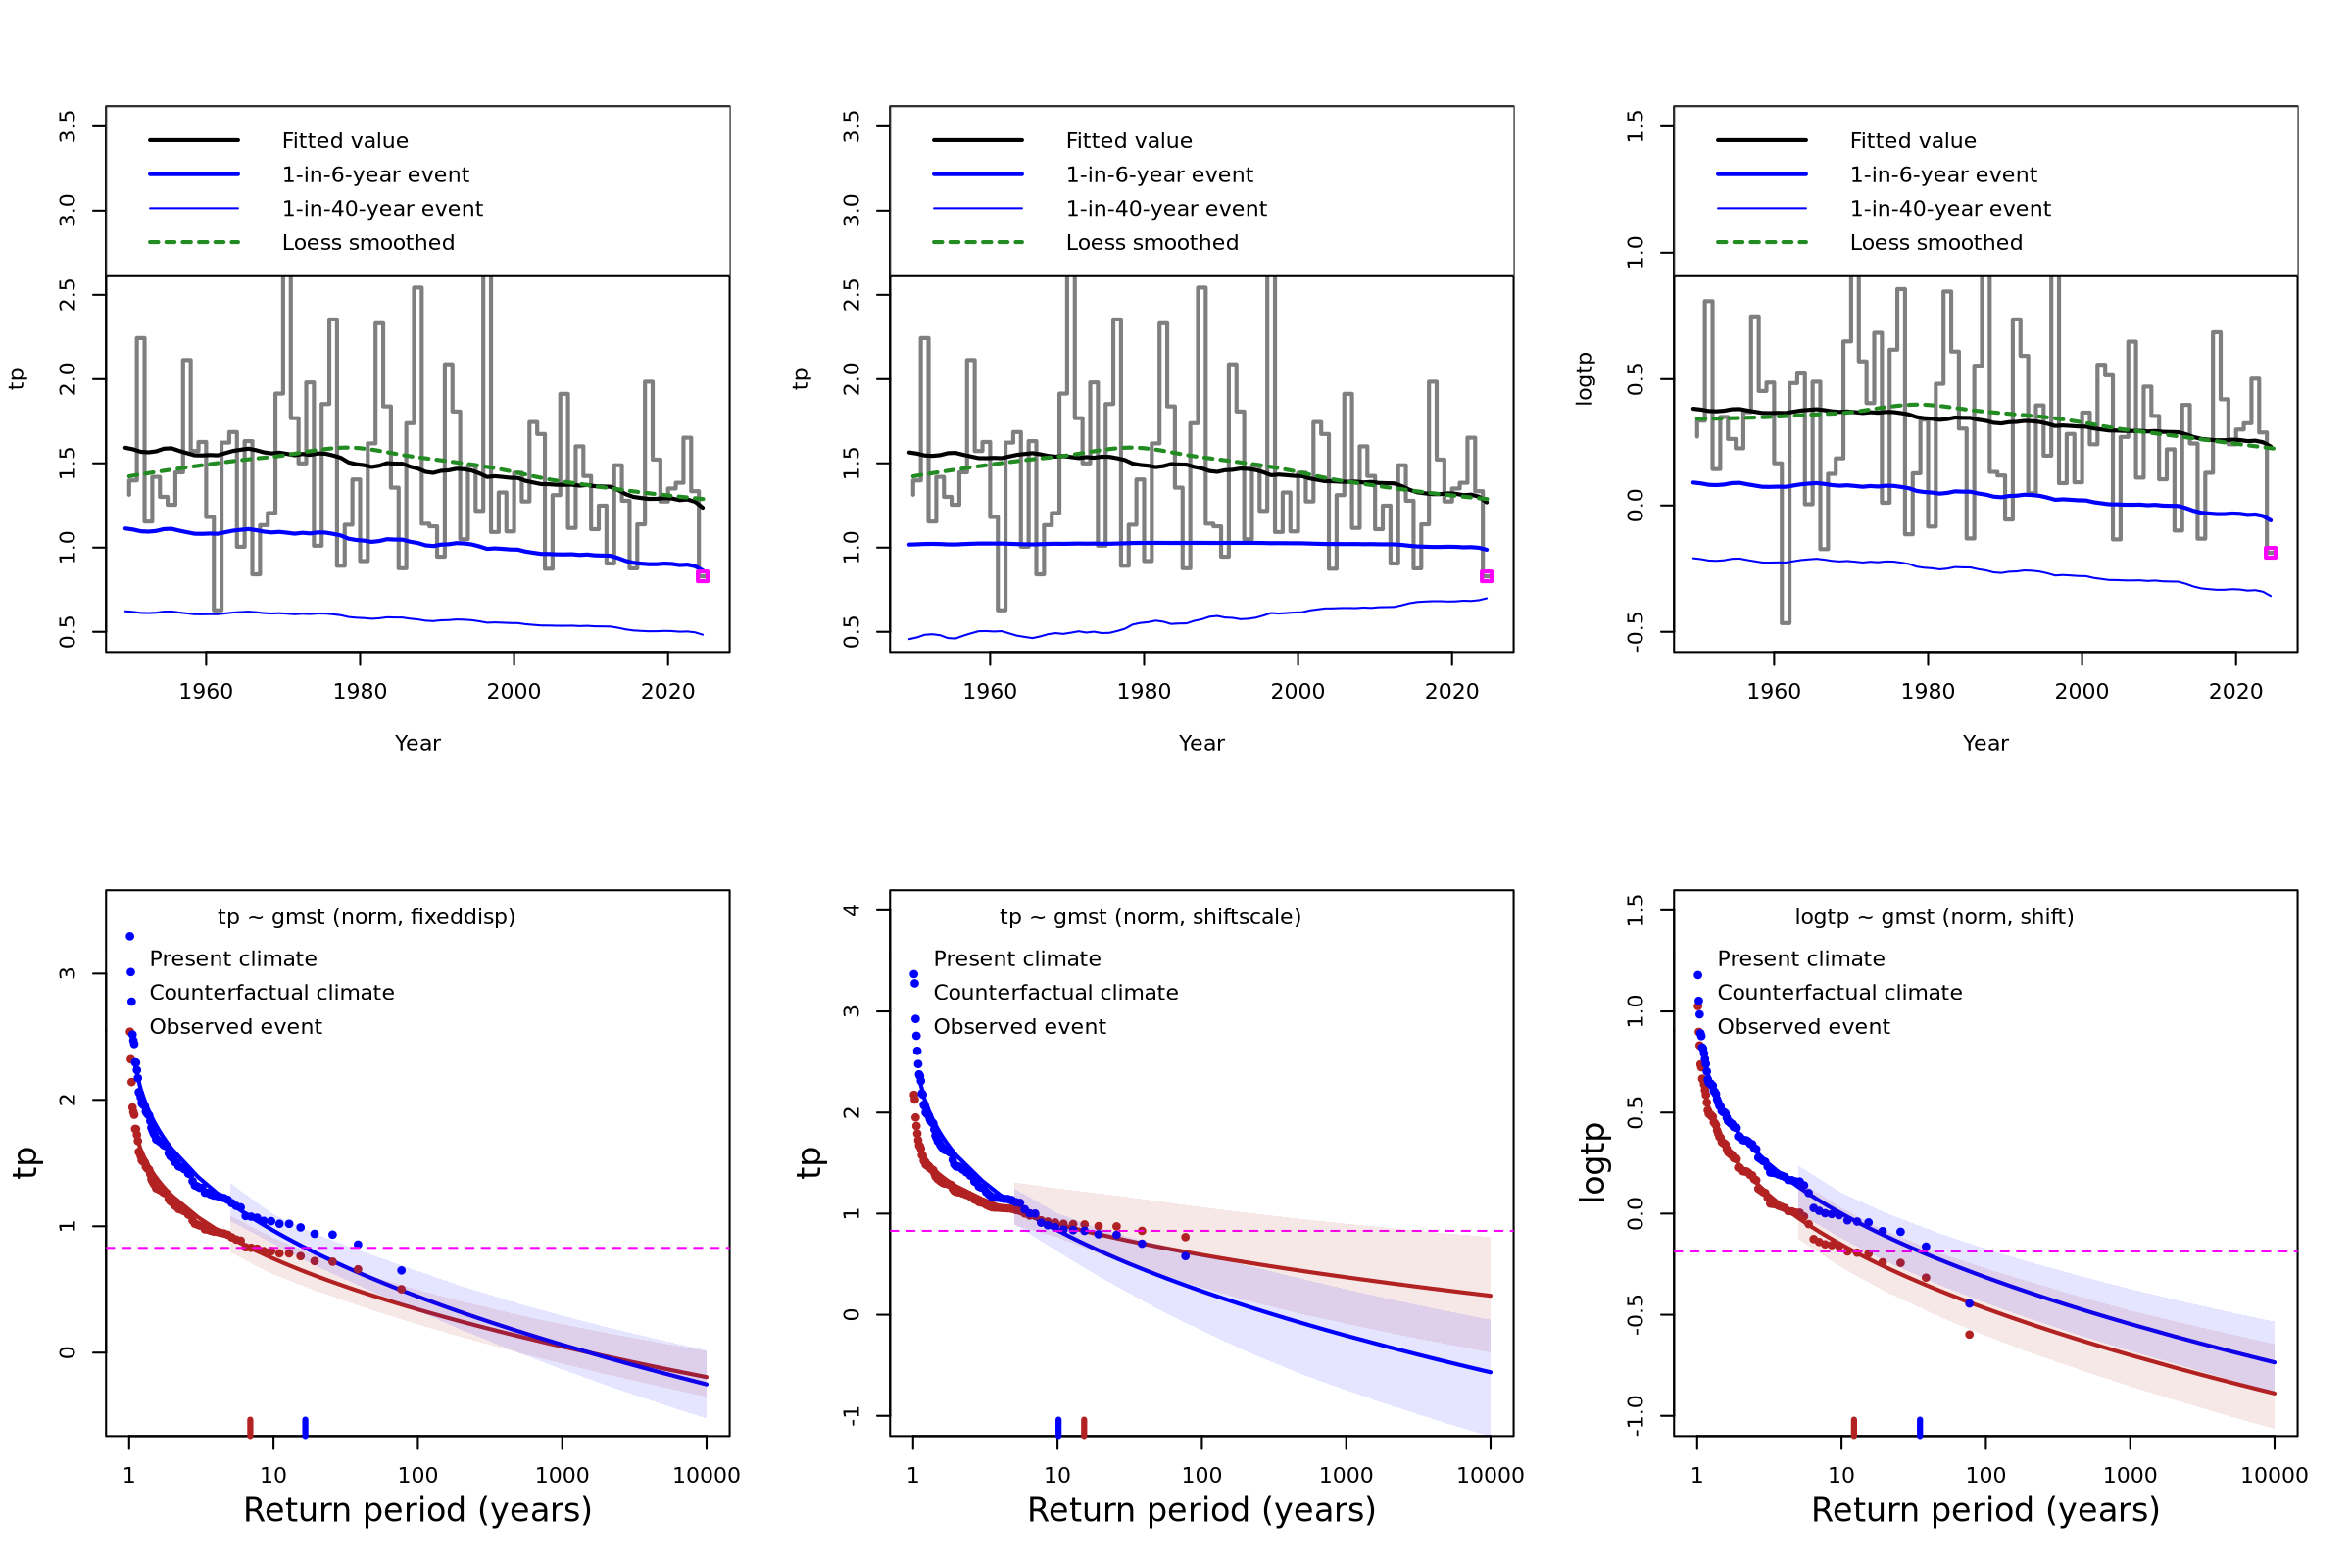

In [49]:
prep_window(c(2,3))

plot_trend(mdl_norm)
plot_trend(mdl_normss)
plot_trend(mdl_normlog)

plot_returnlevels(mdl_norm, cov_f = cov_2024, cov_cf = cov_cf, nsamp = 50)
plot_returnlevels(mdl_normss, cov_f = cov_2024, cov_cf = cov_cf, nsamp = 50)
plot_returnlevels(mdl_normlog, cov_f = cov_2024, cov_cf = cov_cf, nsamp = 50)

In [54]:
mdl_normlog$value + sum(mdl_normlog$x)

[1] 41.87261

In [ ]:
s